In [41]:


import pickle
from dataclasses import dataclass
from pathlib import Path
from typing import List

import numpy as np
import torch
from detectron2.structures import Boxes
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torch.utils.data import RandomSampler
from torchvision import transforms as tf
from torchvision.datasets import ImageFolder
from torchvision.datasets import Kitti
from tqdm import tqdm
from xgboost.sklearn import XGBClassifier

from grit.modeling.meta_arch.grit import GRiT
from main import get_model

In [1]:
@dataclass
class ModelArgs:
    config_file: str
    test_task: str
    opts: List[str]
    confidence_threshold: float = 0.5

args_densecap = ModelArgs(
    config_file='config/gritty.yaml',
    test_task="DenseCap",
    opts=["MODEL.WEIGHTS", "models/grit_b_densecap_objectdet.pth"]
)
args_finetuned = ModelArgs(
    config_file='config/finetuned_gritty.yaml',
    test_task="DenseCap",
    opts=[]
)

grit_model, input_format, aug, cfg = get_model(args_densecap)
grit_model_finetuned, input_format_finetuned, aug_finetuned, cfg_finetuned = get_model(args_finetuned)

In [39]:
def train_classifier(model: GRiT, aug, data_loader: DataLoader):
    model.eval()
    model.roi_heads.finetune = False

    shapenet_object_features = []
    shapenet_labels = []

    n_skipped = 0

    with torch.no_grad():
        for batch, (images, labels) in enumerate(tqdm(data_loader)):
            for i, image in enumerate(images):
                image = image.numpy().transpose(1, 2, 0)
                height, width = image.shape[:2]
                image = aug.get_transform(image).apply_image(image)
                image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
                inputs = [{"image": image, "height": height, "width": width}]

                predictions, stuff = model.forward(inputs)

                instances = predictions[0]["instances"]
                if len(instances.pred_boxes) < 1:
                    n_skipped += 1
                    continue

                # print("found one")
                # plt.imshow(image.numpy().astype("int").transpose(1, 2, 0))
                # print(instances)
                # exit = True
                # break

                n_instances, _, _ = instances.object_features.shape
                shapenet_object_features.extend(instances.object_features.cpu())
                shapenet_labels.extend(np.repeat(labels[i].item(), n_instances))

            if len(shapenet_object_features) > 500:
                break

    shapenet_features = torch.stack(shapenet_object_features)
    shapenet_features = shapenet_features.flatten(start_dim=1)

    x_train, x_test, y_train, y_test = train_test_split(
        shapenet_features, shapenet_labels, test_size=0.2, random_state=42
    )

    classifier = XGBClassifier(predictor="gpu_predictor", gpu_id=model.device.index)
    classifier.fit(x_train, y_train)

    accuracy = classifier.score(x_test, y_test)
    print(f"accuracy: {accuracy}")
    print(f"skipped {n_skipped} images")

    return classifier

In [42]:
shapenet_img_root = Path("data/car_images")
transform = tf.Compose([
    tf.Resize((200, 200)),
    tf.PILToTensor(),
])
shapenet_dataset = ImageFolder(shapenet_img_root, transform=transform)
indices = np.random.choice(np.arange(len(shapenet_dataset)), size=1000)
subset = Subset(shapenet_dataset, indices)
# sampler = RandomSampler(data_source=shapenet_dataset)
shapenet_data_loader = DataLoader(subset, batch_size=8, shuffle=False)

classifier = train_classifier(grit_model, aug, shapenet_data_loader)
classifier_finetuned = train_classifier(grit_model_finetuned, aug_finetuned, shapenet_data_loader)

 24%|██▍       | 30/125 [00:52<02:45,  1.74s/it]


accuracy: 0.7864077669902912
skipped 0 images


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


accuracy: 0.3783783783783784
skipped 916 images


In [2]:
data_path = Path("data/classifier")

with open(data_path / f'xgboost_classifier.pickle', 'rb') as handle:
    classifier: XGBClassifier = pickle.load(handle)

In [3]:
transform = tf.Compose([
    # tf.Resize((200, 200)),
    tf.PILToTensor(),
])

dataset = Kitti("/home/markus/dev/EgoNet", transform=transform, download=False)
data_loader = DataLoader(dataset, batch_size=1)

In [4]:
pi_half = np.pi / 2
MAPPING = {0: 'BACK_LEFT', 1: 'BACK_RIGHT', 2: 'FRONT_LEFT', 3: 'FRONT_RIGHT'}
REVERSE_MAPPING = { v: k for k, v in MAPPING.items() }
TRUNCATED_THRESHOLD = 0.5
OCCLUSION_CLASS = 0

def get_alpha_class(alpha: float) -> str:
    if alpha <= 0 and alpha > -pi_half:
        return 'BACK_LEFT'
    elif alpha <= -pi_half and alpha > -np.pi:
        return 'BACK_RIGHT'
    elif alpha <= np.pi and alpha > pi_half:
        return 'FRONT_RIGHT'
    elif alpha <= pi_half and alpha > 0:
        return 'FRONT_LEFT'

grit_model.eval()

gt_classes = []
predicted_classes = []

images_per_class = {
    0: [],
    1: [],
    2: [],
    3: []
}

with torch.no_grad():
    for images, targets in tqdm(data_loader):
        image = images[0]
        classes = []
        inputs = []
        image_boxes = []

        # if len(images_per_class[0]) > 10 and len(images_per_class[1]) > 10 and len(images_per_class[2]) > 10 and len(images_per_class[3]) > 10:
        #     break

        for i, target in enumerate(targets):
            if target['type'][0] != 'Car' or target['truncated'][0] > TRUNCATED_THRESHOLD or target['occluded'][0] != OCCLUSION_CLASS:
                continue

            alpha_class = get_alpha_class(target['alpha'][0])
            # x_min, y_min, x_max, y_max
            classes.append(alpha_class)

            x_min, y_min, x_max, y_max = target['bbox']
            image_boxes.append((x_min[0], y_min[0], x_max[0], y_max[0]))

        boxes = Boxes(image_boxes)
        boxes = boxes.to(torch.device("cuda"))

        # TODO: do not do it this way around..
        image = image.numpy().transpose(1, 2, 0)
        height, width = image.shape[:2]
        image = aug.get_transform(image).apply_image(image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).to('cuda')

        scale_x, scale_y = (
            image.shape[2] / width,
            image.shape[1] / height,
        )
        boxes.scale(scale_x, scale_y)

        inputs = [{"image": image, "height": height, "width": width}]

        if len(boxes) < 1:
            continue

        _images = grit_model.preprocess_image(inputs)
        features = grit_model.backbone(_images.tensor)
        roi_features = [features[f] for f in grit_model.roi_heads.box_in_features]

        object_features = grit_model.roi_heads.object_feat_pooler(roi_features, [boxes])
        object_features = object_features.view(object_features.shape[0], object_features.shape[1], -1).permute(0, 2, 1).contiguous()

        classifier_features = object_features.to('cpu').flatten(start_dim=1)
        predictions = classifier.predict(classifier_features)

        predicted_classes.extend(predictions)
        gt_classes.extend([REVERSE_MAPPING[c] for c in classes])

        for i, box in enumerate(boxes.tensor):
            x_min, y_min, x_max, y_max = box
            image_box = image.cpu()[:, int(y_min):int(y_max), int(x_min):int(x_max)].clone()

            images_per_class[REVERSE_MAPPING[classes[i]]].append(
                (predictions[i], image_box)
            )

  0%|          | 0/7481 [00:00<?, ?it/s]/home/markus/miniconda3/envs/gritty-transformers/lib/python3.8/site-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))
/home/markus/miniconda3/envs/gritty-transformers/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/Tensor

In [5]:
predicted_classes = np.array(predicted_classes).astype(int)
gt_classes = np.array(gt_classes).astype(int)

print(len(predicted_classes))
print(len(gt_classes))
print(classifier_features.shape)

accuracy = (predicted_classes == gt_classes).sum() / len(gt_classes)

print(accuracy)

11806
11806
torch.Size([2, 50176])
0.431560223615111


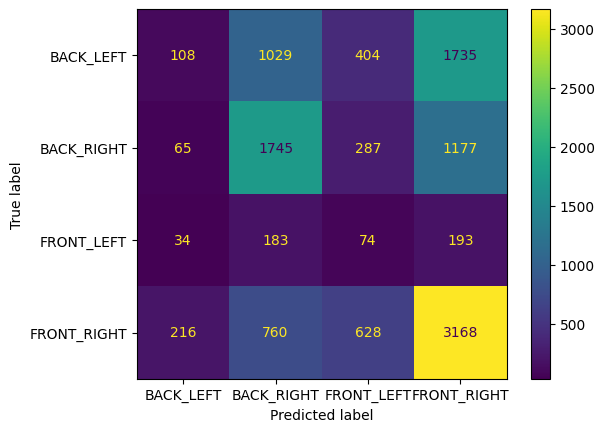

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=gt_classes, y_pred=predicted_classes, display_labels=[
    v for v in MAPPING.values()
])

In [7]:
from bokeh.io import export_png
from bokeh.models import Label
import numpy as np
from bokeh.plotting import figure, show, output_file

from bokeh.layouts import layout
# output_notebook()

# print(shapenet_dataset.class_to_idx)
# {'BACK_LEFT': 0, 'BACK_RIGHT': 1, 'FRONT_LEFT': 2, 'FRONT_RIGHT': 3}

plots = []
for cls, images in images_per_class.items():
    cls_plots = []

    for pred, img in images:
        if len(cls_plots) > 15:
            break
        img = img.type(torch.uint8).cpu().numpy().transpose(1, 2, 0)
        alpha = np.full((img.shape[0], img.shape[1], 1), 255)
        img = np.concatenate((img, alpha), axis=2).astype(np.uint8)
        view = np.ascontiguousarray(img).view("uint32").reshape(img.shape[:2])
        p = figure(width=200, height=200)

        label = Label(x=5, y=10, x_units='screen', y_units='screen', text_alpha=1.0, text_color=(0, 255, 100) if pred == cls else (255, 50, 50), text=f"pred: {MAPPING[pred]}\nGT: {MAPPING[cls]}")
        p.add_layout(label)
        p.image_rgba(image=[view], x=0, y=0, dw=img.shape[1], dh=img.shape[0], origin="top_left")
        p.axis.visible = False
        p.toolbar.logo = None
        p.toolbar_location = None
        p.x_range.range_padding = p.y_range.range_padding = 0
        cls_plots.append(p)

    plots.append(cls_plots)

output_file("xxxxx.html")
fig = layout(plots, sizing_mode="fixed")
show(fig)
export_png(fig, filename="cars.png")

[06/09 13:05:05] selenium.webdriver.common.selenium_manager WARNING: The version of chrome cannot be detected. Trying with latest driver version


RuntimeError: Neither firefox and geckodriver nor a variant of chromium browser and chromedriver are available on system PATH. You can install the former with 'conda install -c conda-forge firefox geckodriver'.

In [ ]:
import numpy as np
import csv

# annotation style of KITTI dataset
FIELDNAMES = ['type',
              'truncated',
              'occluded',
              'alpha',
              'xmin',
              'ymin',
              'xmax',
              'ymax',
              'dh',
              'dw',
              'dl',
              'lx',
              'ly',
              'lz',
              'ry']

TYPE_ID_CONVERSION = {
    'Car': 0,
    'Cyclist': 1,
    'Pedestrian': 2,
}

def csv_read_annot(self, file_path, fieldnames):
    """
    Read instance attributes in the KITTI format. Instances not in the
    selected class will be ignored.

    A list of python dictionary is returned where each dictionary
    represents one instsance.
    """
    annotations = []
    with open(file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file, delimiter=' ', fieldnames=fieldnames)
        for line, row in enumerate(reader):
            if row["type"] in self._classes:
                annot_dict = {
                    "class": row["type"],
                    "label": TYPE_ID_CONVERSION[row["type"]],
                    "truncation": float(row["truncated"]),
                    "occlusion": float(row["occluded"]),
                    "alpha": float(row["alpha"]),
                    "dimensions": [float(row['dl']),
                                   float(row['dh']),
                                   float(row['dw'])
                                   ],
                    "locations": [float(row['lx']),
                                  float(row['ly']),
                                  float(row['lz'])
                                  ],
                    "rot_y": float(row["ry"]),
                    "bbox": [float(row["xmin"]),
                             float(row["ymin"]),
                             float(row["xmax"]),
                             float(row["ymax"])
                             ]
                }
                if "score" in fieldnames:
                    annot_dict["score"] = float(row["score"])
                annotations.append(annot_dict)
    return annotations

def csv_read_calib(self, file_path):
    """
    Read camera projection matrix in the KITTI format.
    """
    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=' ')
        for line, row in enumerate(reader):
            if row[0] == 'P2:':
                P = row[1:]
                P = [float(i) for i in P]
                P = np.array(P, dtype=np.float32).reshape(3, 4)
                break
    return P

def load_annotations(self, label_path, calib_path, fieldnames=FIELDNAMES):
        """
        Read 3D annotation and camera parameters.
        """
        if self.split in ['train', 'valid', 'trainvalid', 'test']:
            annotations = self.csv_read_annot(label_path, fieldnames)
        # get camera intrinsic matrix K
        P = self.csv_read_calib(calib_path)
        return annotations, P